mask sum === :  102138
mask sum:  102138
mask.shape (2048, 3072)
mask.shape 2048
mask sum:  102138
mask.shape (2048, 3072)
mask.shape 2048
mask sum:  102138
mask.shape (2048, 3072)
mask.shape 2048
mask sum:  102138
mask.shape (2048, 3072)
mask.shape 2048


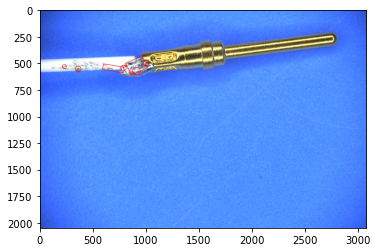

In [9]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
"""
@File    ：detect.py
@Author  ：zhaolin
@Date    ：2022/3/31 14:27
"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def imwrite(filename, file):
    dir = os.path.join(os.getcwd(), 'data-5-18')
    if not os.path.exists(dir):
        os.makedirs(dir)
    cv2.imwrite(os.path.join(dir, filename), file)

def showImg(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)


def findMax(contours):
    result = contours[0]
    for contour in contours:
        if cv2.contourArea(result) < cv2.contourArea(contour):
            result = contour
    return result


#1.提取白色部分，转二值图
image = cv2.imread("/Users/zhouxinyu/论文:电子资料/项目/电缆ZF项目/数据/Image/绝缘层污染 (19).tif")
image = cv2.multiply(image, (1.2, 1.2, 1.2, 1.2))
minWrite = np.array([150, 150, 150])
maxWrite = np.array([255, 255, 255])
mask = cv2.inRange(image, minWrite, maxWrite)
write = cv2.bitwise_and(image, image, mask=mask)

write = cv2.cvtColor(write, cv2.COLOR_BGR2GRAY)
write = cv2.GaussianBlur(write, (5, 5), 0, 0)
write = cv2.threshold(write, 128, 255, cv2.THRESH_BINARY)[1]


#2.将白色部分切成小段
contours = cv2.findContours(write, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
contour = findMax(contours)
temp = np.zeros(write.shape, np.uint8)
cv2.drawContours(temp, [contour], -1, 255, -1)

x, y, w, h = cv2.boundingRect(contour)
mask = np.zeros(write.shape, np.uint8)
mask[y:y + h, x + 50:x + w - 50] = 1
temp = cv2.bitwise_and(temp, mask)
temp = cv2.bitwise_and(temp,write)

step = 250
n = w // step
step = step + (w % step) // n
line = []
print("mask sum === : ", sum(sum(temp)))
for i in range(n):
    mask = np.zeros(write.shape, np.uint8)
    print("mask sum: ", sum(sum(temp)))
    print("mask.shape", mask.shape)
    print("mask.shape", len(mask))
    mask[:, x + step * i:x + step * (i + 1)] = 1
    # print("mask: ", sum(sum(temp)))
    part = cv2.bitwise_and(temp, mask)
    line.append(part)


#3.找缺陷：找最大轮廓凸集，在最大轮廓上覆盖，用圆形和矩形标记
draw = np.zeros(write.shape, np.uint8)
for part in line:
    temp = np.zeros(write.shape, np.uint8)
    contours = cv2.findContours(part, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    for contour in contours:
        if cv2.contourArea(contour) > 100:
            cv2.drawContours(temp, [contour], -1, 255, 3)

    contour = findMax(contours)
    hull = cv2.convexHull(contour)
    cv2.drawContours(temp, [hull], -1, 0, 15)
    draw = cv2.bitwise_or(draw, temp)

# plt.imshow(draw,cmap="gray")
# plt.show()

contours = cv2.findContours(draw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
for contour in contours:
    if cv2.contourArea(contour) > 1000:
        rect = cv2.minAreaRect(contour)
        points = cv2.boxPoints(rect)
        points = np.int0(points)
        cv2.drawContours(image, [points], 0, (0, 0, 255), 3)
        
    elif cv2.contourArea(contour) > 50:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        radius = int(radius)
        x, y = int(x), int(y)
        cv2.circle(image, [x, y], radius, (0, 0, 255), 3)

imwrite('绝缘层污染3-结果.png', image)
showImg(image)
plt.show()